In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import json
import tensorflow as tf
import gc

import matplotlib.pyplot as plt
%matplotlib inline  

import mplhep as hep
plt.style.use(hep.style.ROOT)

#import atlas_mpl_style as ampl
#ampl.use_atlas_style()

# Open Boosted events file

In [2]:
def open_boosted(path= ""):
    '''
    This function will get a .npz file and transform into a pandas DataFrame. 
    The .npz has three types of data: float, int and bool this function will concatenate these features and reorder them.

    Arguments:
    path (str) - the full path to .npz file
    '''
    # open the file
    d = dict(np.load(path, allow_pickle=True))   
    #print(d.keys()) 
    # create a list of temporary dataframes that should be concateneted into a final one
    df_list = []
    for itype in ['float', 'int', 'bool', 'object']:
        df_list.append(pd.DataFrame(data=d['data_%s' %itype], columns=d['features_%s' %itype]))
    # concat the list
    df = pd.concat(df_list, axis=1)
    # return the DataFrame with ordered features.
    df = df[d['ordered_features']]
    # add the target information
    df['target'] = d['target']
    df['et_bin'] = d['etBinIdx']
    df['eta_bin'] = d['etaBinIdx']
    # remove the list of DataFrame and collect into garbage collector
    del df_list, d
    gc.collect()
    
    #rename some columns to match in analysis
    rename_columns={'el_et': 'et','el_eta':'eta',
                    'el_phi':'phi','el_rhad1':'rhad1',
                    'el_rhad':'rhad','el_f3':'f3',
                    'el_weta2':'weta2','el_rphi':'rphi',
                    'el_reta':'reta','el_wtots1':'wtots1',
                    'el_eratio':'eratio','el_f1':'f1',
                    'el_hastrack':'hastrack',
                    'el_numberOfBLayerHits':'numberOfBLayerHits',
                    'el_numberOfPixelHits':'numberOfPixelHits',
                    'el_numberOfTRTHits':'numberOfTRTHits',
                    'el_d0':'d0','el_d0significance':'d0significance',
                    'el_eProbabilityHT':'eProbabilityHT',
                    'el_trans_TRT_PID':'trans_TRT_PID',
                    'el_deltaEta1':'deltaEta1','el_deltaPhi2':'deltaPhi2',
                    'el_deltaPhi2Rescaled':'deltaPhi2Rescaled',
                    'el_deltaPOverP':'deltaPOverP',
                   }
    df.rename(columns=rename_columns, inplace=True)
    return df

In [3]:
# my pc path
#data_path = '/media/natmourajr/Backup/Work/CERN/Qualify/cern_data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et4_eta0.npz'
# LPS path
data_path = '/home/natmourajr/Workspace/CERN/Qualify/data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et4_eta0.npz'
df_boosted = open_boosted(data_path)

In [4]:
df_boosted.head()

,RunNumber,avgmu,trig_L2_cl_et,trig_L2_cl_eta,trig_L2_cl_phi,trig_L2_cl_reta,trig_L2_cl_ehad1,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,...,trig_L2_cl_lhtight_et0to12,trig_L2_cl_lhtight_et12to20,trig_L2_cl_lhtight_et22toInf,trig_L2_el_cut_pt0to15,trig_L2_el_cut_pt15to20,trig_L2_el_cut_pt20to50,trig_L2_el_cut_pt50toInf,target,et_bin,eta_bin
0,300000,46.5,1187730.500,0.400507,0.212308,0.966145,1612.466919,0.995495,0.102619,0.009935,...,True,True,True,True,True,True,True,1.0,4,0
1,300000,46.5,1187730.500,0.400507,0.212308,0.966145,1612.466919,0.995495,0.102619,0.009935,...,True,True,True,True,True,True,True,1.0,4,0
2,300000,37.5,1169499.375,0.289294,-1.428020,0.974601,4729.030762,0.993501,0.090885,0.014455,...,True,True,True,True,True,True,True,1.0,4,0
3,300000,38.5,1239348.125,-0.114279,2.722416,0.975350,11178.170898,0.991390,0.054241,0.021975,...,True,True,True,True,True,True,True,1.0,4,0
4,300000,38.5,1239348.125,-0.114279,2.722416,0.975350,11178.170898,0.991390,0.054241,0.021975,...,True,True,True,True,True,True,True,1.0,4,0


In [5]:
#list(df_boosted.columns)

# Add Tuning decision for boosted

In [6]:
def add_tuning_decision_boosted(df, tuning_path, config_dict):
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
            sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['trig_L2_cl_ring_%i' %(iring) for iring in range(100)] 

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s'%(config_dict['__operation__'].lower(),config_dict['__version__'])] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 0
        df.loc[df['nn_output_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 1 


In [7]:
trigger_operation_points = ['VeryLoose','Loose', 'Medium', 'Tight']
ringer_versions = ['TrigL2_20180125_v8'] 
#ringer_versions = ['TrigL2_20180125_v8','TrigL2_20210907_v8-1'] 
#ringer_versions = ['TrigL2_20210907_v8-1'] 

for i_ringer_version in ringer_versions:
    for i_trigger_operation_point in trigger_operation_points:
        tuning_path = '../tunings/%s'%(i_ringer_version)
        tuning_file = "ElectronRinger%sTriggerConfig.json"%(i_trigger_operation_point)
        print('Processing %s'%os.path.join(tuning_path,tuning_file))
        with open(os.path.join(tuning_path,tuning_file)) as f:
            conf = json.load(f)
        #print(conf)
        add_tuning_decision_boosted(df=df_boosted, tuning_path=tuning_path, config_dict=conf)

Processing ../tunings/TrigL2_20180125_v8/ElectronRingerVeryLooseTriggerConfig.json
Processing ../tunings/TrigL2_20180125_v8/ElectronRingerLooseTriggerConfig.json
Processing ../tunings/TrigL2_20180125_v8/ElectronRingerMediumTriggerConfig.json
Processing ../tunings/TrigL2_20180125_v8/ElectronRingerTightTriggerConfig.json


In [8]:
df_boosted.head()

,RunNumber,avgmu,trig_L2_cl_et,trig_L2_cl_eta,trig_L2_cl_phi,trig_L2_cl_reta,trig_L2_cl_ehad1,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,...,nn_decision_veryloose_v8,nn_output_loose_v8,thr_loose_v8,nn_decision_loose_v8,nn_output_medium_v8,thr_medium_v8,nn_decision_medium_v8,nn_output_tight_v8,thr_tight_v8,nn_decision_tight_v8
0,300000,46.5,1187730.500,0.400507,0.212308,0.966145,1612.466919,0.995495,0.102619,0.009935,...,1,0.674055,-0.167558,1,0.674055,-0.337748,1,0.674055,0.108935,1
1,300000,46.5,1187730.500,0.400507,0.212308,0.966145,1612.466919,0.995495,0.102619,0.009935,...,1,0.674055,-0.167558,1,0.674055,-0.337748,1,0.674055,0.108935,1
2,300000,37.5,1169499.375,0.289294,-1.428020,0.974601,4729.030762,0.993501,0.090885,0.014455,...,1,1.400567,-0.059216,1,1.400567,-0.213292,1,1.400567,0.213524,1
3,300000,38.5,1239348.125,-0.114279,2.722416,0.975350,11178.170898,0.991390,0.054241,0.021975,...,1,1.624149,-0.071254,1,1.624149,-0.227121,1,1.624149,0.201903,1
4,300000,38.5,1239348.125,-0.114279,2.722416,0.975350,11178.170898,0.991390,0.054241,0.021975,...,1,1.624149,-0.071254,1,1.624149,-0.227121,1,1.624149,0.201903,1


# Open Zee

In [8]:
def open_zee(path= ""):
    '''
    This function will get a .npz file and transform into a pandas DataFrame. 
    The .npz has three types of data: float, int and bool this function will concatenate these features and reorder them.

    Arguments:
    path (str) - the full path to .npz file
    '''
    # open the file
    d = dict(np.load(path, allow_pickle=True))
    print(d.keys())
    df = pd.DataFrame(d['data'],columns=d["features"])
    
    df['target'] = d['target']
    df['et_bin'] = d['etBinIdx']
    df['eta_bin'] = d['etaBinIdx']
    return df

In [9]:
# my pc path
#data_path = '/media/natmourajr/Backup/Work/CERN/Qualify/cern_data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et0_eta0.npz'
# LPS path
data_path = '/home/natmourajr/Workspace/CERN/Qualify/data/Zee/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97_et4_eta0.npz'
df_zee = open_zee(data_path)

dict_keys(['features', 'etBins', 'etaBins', 'etBinIdx', 'etaBinIdx', 'data', 'target'])


In [10]:
df_zee.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,el_lhmedium,el_lhloose,el_lhvloose,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,target,et_bin,eta_bin
0,31.459999,946.455200,297.285675,-162.731384,238.094727,-204.648712,112.230659,29.744968,43.871647,4150.571289,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
1,31.420000,1155.483643,231.537582,841.838196,-32.028019,317.318054,412.808563,19.779219,-101.355553,12582.793945,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
2,31.459999,2306.196045,123.935341,-92.987045,-264.076416,172.244553,-83.377022,109.801102,-15.553493,8039.985840,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
3,31.459999,1661.695190,311.053619,-193.597885,-127.421242,386.362854,156.423721,182.063248,-88.269615,6214.927246,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
4,31.459999,716.282349,572.603027,24.837866,-122.357193,-38.153748,-149.753250,205.552399,-74.376228,4822.833984,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0


In [11]:
#list(df_Zee.columns)

# Adding Tuning decision for Zee

In [31]:
def add_tuning_decision_zee(df, tuning_path, config_dict):
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['L2Calo_ring_%i' %(iring) for iring in range(100)] 

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s'%(config_dict['__operation__'].lower(),config_dict['__version__'])] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 0
        df.loc[df['nn_output_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 1 


In [13]:
# tuning_path = '../tunings/TrigL2_20180125_v8'
# tuning_file = "ElectronRingerLooseTriggerConfig.json"
# with open(os.path.join(tuning_path,tuning_file)) as f:
#     conf = json.load(f)
# add_tuning_decision_zee(df=df_zee, tuning_path=tuning_path, config_dict=conf)

In [34]:
trigger_operation_points = ['VeryLoose','Loose', 'Medium', 'Tight']
ringer_versions = ['TrigL2_20180125_v8'] 
#ringer_versions = ['TrigL2_20180125_v8','TrigL2_20210907_v8-1'] 
#ringer_versions = ['TrigL2_20210907_v8-1'] 

for i_ringer_version in ringer_versions:
    for i_trigger_operation_point in trigger_operation_points:
        tuning_path = '../tunings/%s'%(i_ringer_version)
        tuning_file = "ElectronRinger%sTriggerConfig.json"%(i_trigger_operation_point)
        print('Processing %s'%os.path.join(tuning_path,tuning_file))
        with open(os.path.join(tuning_path,tuning_file)) as f:
            conf = json.load(f)
        #print(conf)
        add_tuning_decision_zee(df=df_zee, tuning_path=tuning_path, config_dict=conf)

Processing ../tunings/TrigL2_20180125_v8/ElectronRingerVeryLooseTriggerConfig.json
Processing ../tunings/TrigL2_20180125_v8/ElectronRingerLooseTriggerConfig.json
Processing ../tunings/TrigL2_20180125_v8/ElectronRingerMediumTriggerConfig.json
Processing ../tunings/TrigL2_20180125_v8/ElectronRingerTightTriggerConfig.json


In [35]:
df_zee.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,nn_decision_loose_v8,nn_output_veryloose_v8,thr_veryloose_v8,nn_decision_veryloose_v8,nn_output_medium_v8,thr_medium_v8,nn_decision_medium_v8,nn_output_tight_v8,thr_tight_v8,nn_decision_tight_v8
0,31.459999,946.455200,297.285675,-162.731384,238.094727,-204.648712,112.230659,29.744968,43.871647,4150.571289,...,0,-1.728537,-0.534219,0,-1.728537,-0.129769,0,-1.728537,0.283715,0
1,31.420000,1155.483643,231.537582,841.838196,-32.028019,317.318054,412.808563,19.779219,-101.355553,12582.793945,...,0,-1.040594,-0.533676,0,-1.040594,-0.129216,0,-1.040594,0.284179,0
2,31.459999,2306.196045,123.935341,-92.987045,-264.076416,172.244553,-83.377022,109.801102,-15.553493,8039.985840,...,0,-1.260863,-0.534219,0,-1.260863,-0.129769,0,-1.260863,0.283715,0
3,31.459999,1661.695190,311.053619,-193.597885,-127.421242,386.362854,156.423721,182.063248,-88.269615,6214.927246,...,0,-1.103993,-0.534219,0,-1.103993,-0.129769,0,-1.103993,0.283715,0
4,31.459999,716.282349,572.603027,24.837866,-122.357193,-38.153748,-149.753250,205.552399,-74.376228,4822.833984,...,0,-1.382297,-0.534219,0,-1.382297,-0.129769,0,-1.382297,0.283715,0


# Filter events

In [38]:
df_sgn = df_zee[(df_zee.target==1) & (df_zee.el_lhmedium ==1)] #treinamento dos modelos em 2017
df_bkg = df_zee[(df_zee.target!=1) & (df_zee.el_lhvloose !=1)] # além de vir de uma amostra de bkg e tem que ser reprovadas no vloose

In [46]:
print('Quantidade de Jatos:',df_bkg.shape[0])
print('Quantidade de Eletrons:',df_sgn.shape[0])
print('Quantidade de Boosted:',df_boosted.shape[0])

Quantidade de Eletrons: 1699541
Quantidade de Jatos: 3769656
Quantidade de Boosted: 39199


# Plot everything

In [41]:
from matplotlib import gridspec

def plot_turn_on(df_sgn, df_bkg, df_boosted, variable, target_variable, ringer_variable, bins, verbose=False, set_ylog = False):
    '''
        plot_turn_on: Função que plota o histograma de eficiencia por uma determinada variavel.
        A eficiencia deve ser medida em um ponto de operação, assim sendo, temos as entradas
        (diferentes dfs) a variavel de interesse (variable), a variavel que determina o padrão-
        -ouro do trigger e a saída do trigger na versão a ser analisada.
    '''
    
    #create a figure
    figsize = (13,12)
    nrows = 2
    ncols = 1
    fig = plt.figure(figsize=figsize)
    
    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                             width_ratios=[1],
                             height_ratios=[2.5, 1],
                             wspace=0.0, hspace=0.1,)
    
    # ax0 will take 0th position in
    # geometry(Grid we created for subplots),
    # as we defined the position as "spec[0]"
    ax  = fig.add_subplot(spec[0])
    ax1 = fig.add_subplot(spec[1])
    ax1.sharex(ax)
    #ax.set_xticks(color='w')
    ax.tick_params(axis="x", colors="None")
    #ax = plt.subplot(nrows,ncols, 1, gridspec_kw={'width_ratios': [3, 1]}))
    
    data = [df_sgn, df_bkg, df_boosted]
    labels = ['sgn', 'bkg', 'boosted']
    colors = ['blue', 'red', 'green']
    
    check_flag = True
    
    for idb in data:
        if not variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'variable:', variable)
    if not check_flag:
        print('Choose variable (%s) is not in database'%(variable))
        return -1
    
    
    for idb in data:
        if not target_variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'target_variable:', target_variable)
    if not check_flag:
        print('Target variable (%s) is not in database'%(target_variable))
        return -1
    
    
    for idb in data:
        if not ringer_variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'ringer_variable:', ringer_variable)
    if not check_flag:
        print('Ringer variable (%s) is not in database'%(ringer_variable))
        return -1
    
    
    if bins is None:
        n_bins = 10 # meu padrão
        # calculo do minino dos minimos e do maximo dos maximos
        m_min = +999999999999
        m_max = -999999999999
        for idb in data:
            if idb[variable].min() < m_min:
                m_min = idb[variable].min()
            if idb[variable].max() > m_max:
                m_max = idb[variable].max()
        bins = np.round(np.linspace(m_min, m_max, n_bins),2)
    else:
        n_bins = len(bins)
    if verbose: print('used bins:',bins)
    
    eff_per_bins = np.zeros([len(data),len(bins)])
    bin_center = np.zeros_like(bins)
    
    for idx,idb in enumerate(data):
        if verbose: print('processing',labels[idx])
        n, m_bins, patches = ax.hist(idb[variable], bins, density=True, 
                                     color=colors[idx], alpha=1.0, 
                                     label=labels[idx], histtype='step', lw=1.5)
        # plota a eficiencia pela variavel escolhida
        for id_bin, m_bin in enumerate(bins):
            if id_bin+1 == n_bins:
                break
            if verbose: print('bin low', bins[id_bin])
            if verbose: print('bin high', bins[id_bin+1])
            
            total_true_trigger = idb.query('%1.2f < %s <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1])).shape[0]
            total_accept_trigger = idb.query('%1.2f < %s <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1]))[ringer_variable].sum()
            
            if verbose: print('total true',total_true_trigger)
            if verbose: print('total accepted',total_accept_trigger)
            
            if total_accept_trigger != 0.0 :
                eff_per_bins[idx,id_bin]=float(total_accept_trigger)/float(total_true_trigger)
            else:
                eff_per_bins[idx,id_bin] = 0.0
            bin_center[id_bin] = bins[id_bin]+ ((bins[id_bin+1]-bins[id_bin])/2)
            
        ax1.plot(bin_center,eff_per_bins[idx,:],'o',color=colors[idx], alpha=0.75, label=labels[idx])
    #ax1.set_ylim([0,1.15])
    (ylim_low, ylim_high) = ax.get_ylim()
    #ax.set_ylim([ylim_low, 1.5*ylim_high])
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Trigger Eff')
    ax1.set_yscale('log')
    if set_ylog: ax.set_yscale('log')
    ax.set_ylabel('PDF (Norm. Area)')
    ax.legend(bbox_to_anchor=(0,0.92,1,0.2), mode='expand', loc="upper left", ncol=3)
    #ax1.legend(loc='best', ncol=3)
    
    (ylim_low, ylim_high) = ax.get_ylim()
    (xlim_low, xlim_high) = ax.get_xlim()
    
    #hep.atlas.text('Prelimiary', ax=ax, loc=1)
    #ax.text(x=0.2*xlim_low, y=0.80*ylim_high, s='$\sqrt{s} = 13$ TeV', fontsize=20)
    #ax.text(x=0.2*xlim_low, y=0.73*ylim_high, s='Data 2018', fontsize=20)
    #ax.text(x=0.2*xlim_low, y=0.65*ylim_high, s='$\int\, Ldt = 43.8\ fb^{-1}$', fontsize=20)
    #ax1.text(x=r_edges.min(), y=0.8*new_y_size,
    #        s='%i $\leq E_T$ < %i GeV' %(etlist[etbin], 
    #                                    etlist[etbin+1]),
    #        fontsize=15)
    #ax1.text(x=r_edges.min(), y=0.7*new_y_size, 
    #        s='%1.2f $\leq \eta$ < %1.2f' %(etalist[etabin], 
    #                                        etalist[etabin+1]), 
    #                                        fontsize=15)
    
    ax.grid()
    ax1.grid()
     
    plt.tight_layout()
    return [fig,ax,ax1]


from matplotlib import gridspec

def plot_et_turn_on(df_sgn, df_bkg, df_boosted, variable, target_variable, ringer_variable, bins, verbose=False):
    '''
        plot_et_turn_on: Função que plota o histograma de eficiencia por uma determinada variavel.
        A eficiencia deve ser medida em um ponto de operação, assim sendo, temos as entradas
        (diferentes dfs) a variavel de interesse (variable), a variavel que determina o padrão-
        -ouro do trigger e a saída do trigger na versão a ser analisada.
    '''
    
    #create a figure
    figsize = (13,12)
    nrows = 2
    ncols = 1
    fig = plt.figure(figsize=figsize)
    
    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                             width_ratios=[1],
                             height_ratios=[2.5, 1],
                             wspace=0.0, hspace=0.1,)
    
    # ax0 will take 0th position in
    # geometry(Grid we created for subplots),
    # as we defined the position as "spec[0]"
    ax  = fig.add_subplot(spec[0])
    ax1 = fig.add_subplot(spec[1])
    ax1.sharex(ax)
    #ax.set_xticks(color='w')
    ax.tick_params(axis="x", colors="None")
    #ax = plt.subplot(nrows,ncols, 1, gridspec_kw={'width_ratios': [3, 1]}))
    
    data = [df_sgn, df_bkg, df_boosted]
    labels = ['sgn', 'bkg', 'boosted']
    colors = ['blue', 'red', 'green']
    
    check_flag = True
    
    for idb in data:
        if not variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'variable:', variable)
    if not check_flag:
        print('Choose variable (%s) is not in database'%(variable))
        return -1
    
    
    for idb in data:
        if not target_variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'target_variable:', target_variable)
    if not check_flag:
        print('Target variable (%s) is not in database'%(target_variable))
        return -1
    
    
    for idb in data:
        if not ringer_variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'ringer_variable:', ringer_variable)
    if not check_flag:
        print('Ringer variable (%s) is not in database'%(ringer_variable))
        return -1
    
    
    if bins is None:
        n_bins = 10 # meu padrão
        # calculo do minino dos minimos e do maximo dos maximos
        m_min = +999999999999
        m_max = -999999999999
        for idb in data:
            if idb[variable].min() < m_min:
                m_min = idb[variable].min()
            if idb[variable].max() > m_max:
                m_max = idb[variable].max()
        bins = np.round(np.linspace(m_min, m_max, n_bins),2)
    else:
        n_bins = len(bins)
    if verbose: print('used bins:',bins)
    
    eff_per_bins = np.zeros([len(data),len(bins)])
    bin_center = np.zeros_like(bins)
    
    for idx,idb in enumerate(data):
        if verbose: print('processing',labels[idx])
        # plota o histograma da variavel escolhida
        # no caso de et, a escala está em MeV e deve ser TeV
        n, m_bins, patches = ax.hist(idb[variable]/1000, bins, density=True, 
                                     color=colors[idx], alpha=1.0, 
                                     label=labels[idx], histtype='step', lw=1.5)
        # plota a eficiencia pela variavel escolhida
        for id_bin, m_bin in enumerate(bins):
            if id_bin+1 == n_bins:
                break
            if verbose: print('bin low', bins[id_bin])
            if verbose: print('bin high', bins[id_bin+1])
            
            # corrigindo a escala
            total_true_trigger = idb.query('%1.2f < %s/1000 <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1])).shape[0]
            total_accept_trigger = idb.query('%1.2f < %s/1000 <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1]))[ringer_variable].sum()
            
            
            if verbose: print('total true',total_true_trigger)
            if verbose: print('total accepted',total_accept_trigger)
            
            if total_accept_trigger != 0.0 :
                eff_per_bins[idx,id_bin]=float(total_accept_trigger)/float(total_true_trigger)
            else:
                eff_per_bins[idx,id_bin] = 0.0
            bin_center[id_bin] = bins[id_bin]+ ((bins[id_bin+1]-bins[id_bin])/2)
            
        ax1.plot(bin_center,eff_per_bins[idx,:],'o',color=colors[idx], alpha=0.75, label=labels[idx])
    #ax1.set_ylim([0,1.15])
    (ylim_low, ylim_high) = ax.get_ylim()
    #ax.set_ylim([ylim_low, 1.5*ylim_high])
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Trigger Eff')
    ax.set_yscale('log')
    ax1.set_yscale('log')
    ax.set_ylabel('PDF (Norm. Area)')
    ax.legend(bbox_to_anchor=(0,0.92,1,0.2), mode='expand', loc="upper left", ncol=3)
    #ax1.legend(loc='best', ncol=3)
    
    (ylim_low, ylim_high) = ax.get_ylim()
    (xlim_low, xlim_high) = ax.get_xlim()
    
    #hep.atlas.text('Prelimiary', ax=ax, loc=1)
    #ax.text(x=0.2*xlim_low, y=0.80*ylim_high, s='$\sqrt{s} = 13$ TeV', fontsize=20)
    #ax.text(x=0.2*xlim_low, y=0.73*ylim_high, s='Data 2018', fontsize=20)
    #ax.text(x=0.2*xlim_low, y=0.65*ylim_high, s='$\int\, Ldt = 43.8\ fb^{-1}$', fontsize=20)
    #ax1.text(x=r_edges.min(), y=0.8*new_y_size,
    #        s='%i $\leq E_T$ < %i GeV' %(etlist[etbin], 
    #                                    etlist[etbin+1]),
    #        fontsize=15)
    #ax1.text(x=r_edges.min(), y=0.7*new_y_size, 
    #        s='%1.2f $\leq \eta$ < %1.2f' %(etalist[etabin], 
    #                                        etalist[etabin+1]), 
    #                                        fontsize=15)
    
    ax.grid()
    ax1.grid()
     
    plt.tight_layout()
    return [fig,ax,ax1]
    
    

Processing VeryLoose - et


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


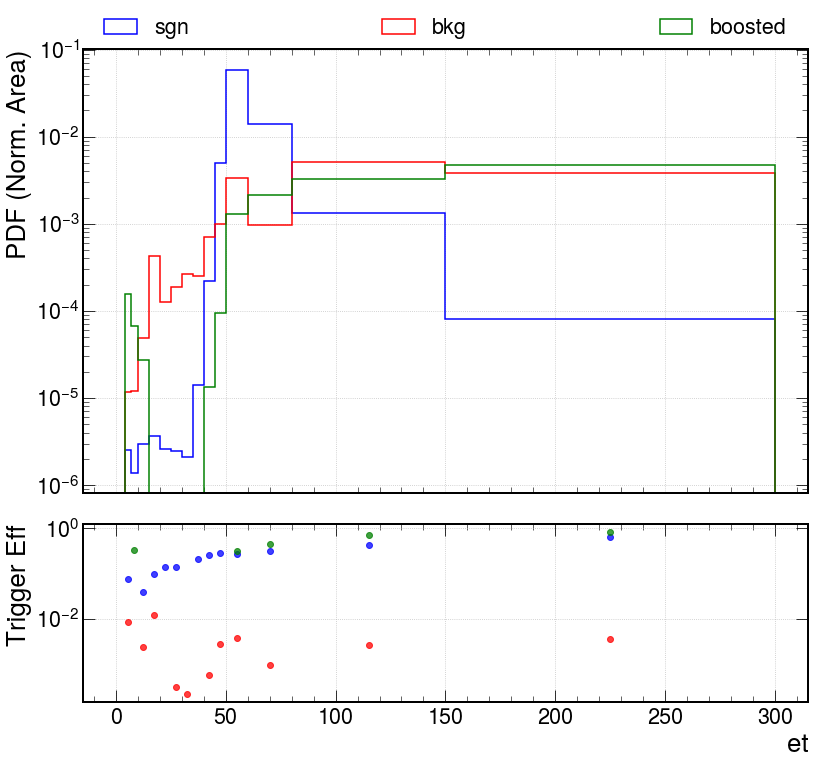

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing VeryLoose - eta


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


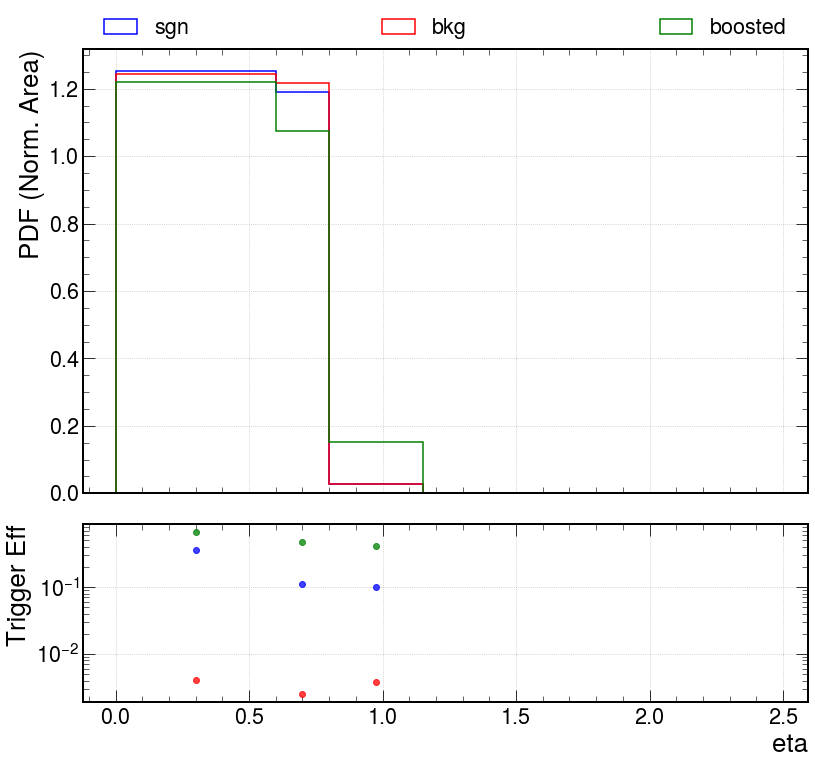

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing VeryLoose - phi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


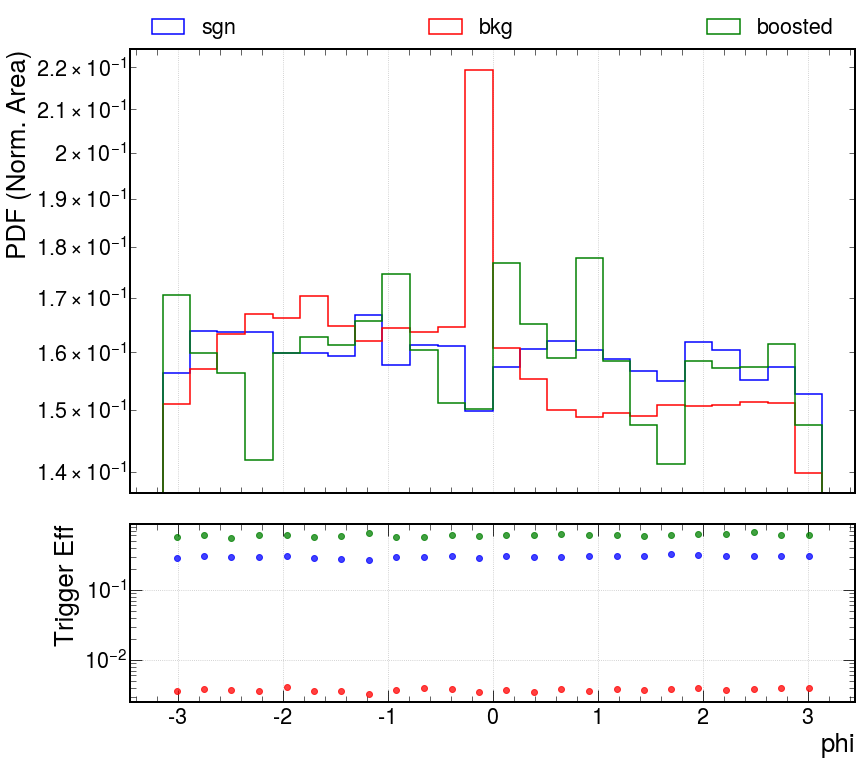

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing VeryLoose - avgmu


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


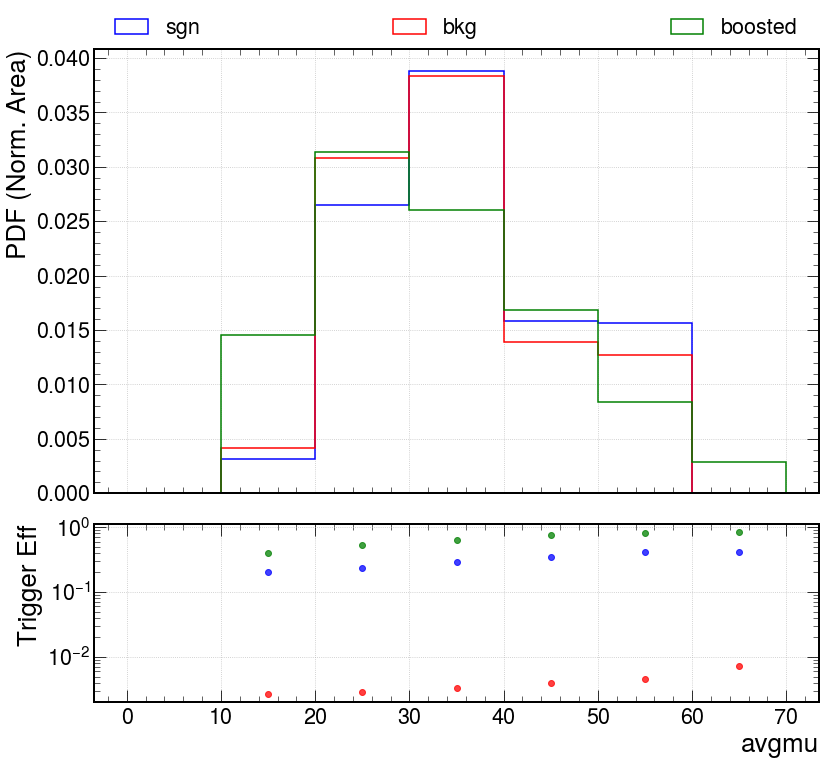

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Loose - et


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


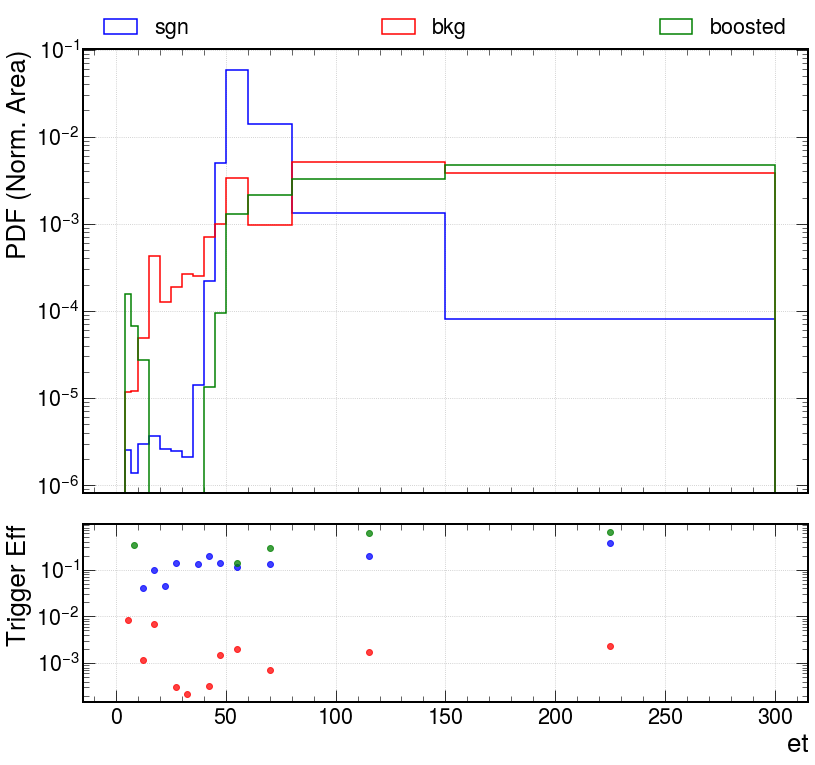

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Loose - eta


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


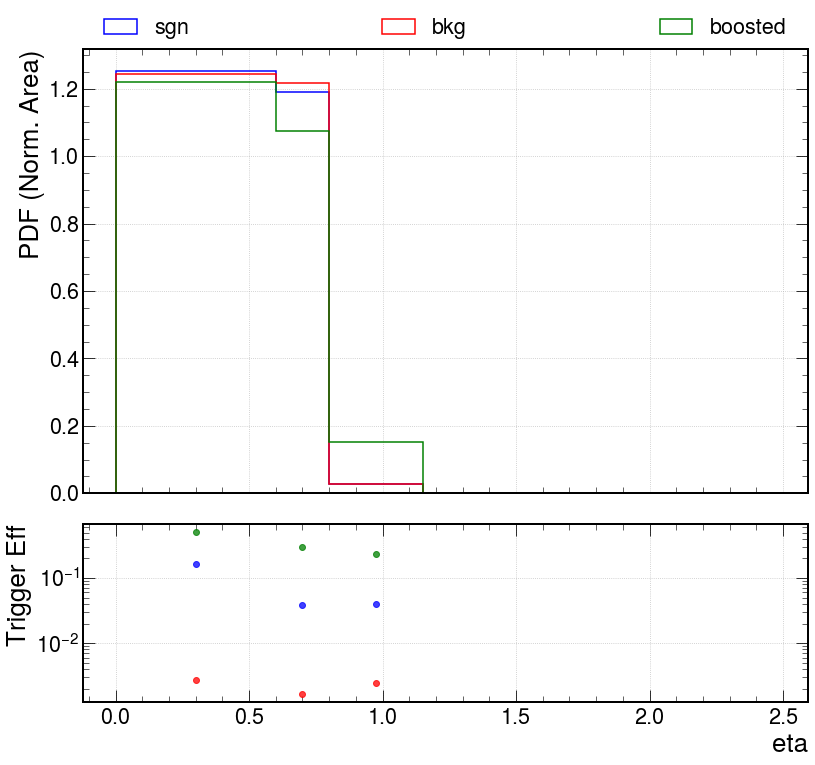

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Loose - phi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


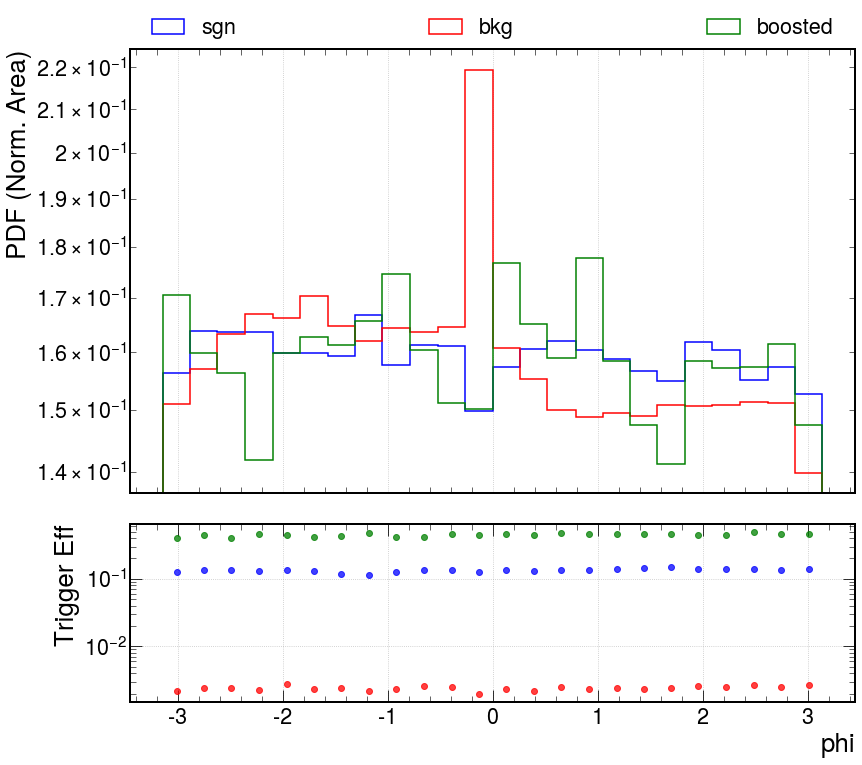

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Loose - avgmu


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


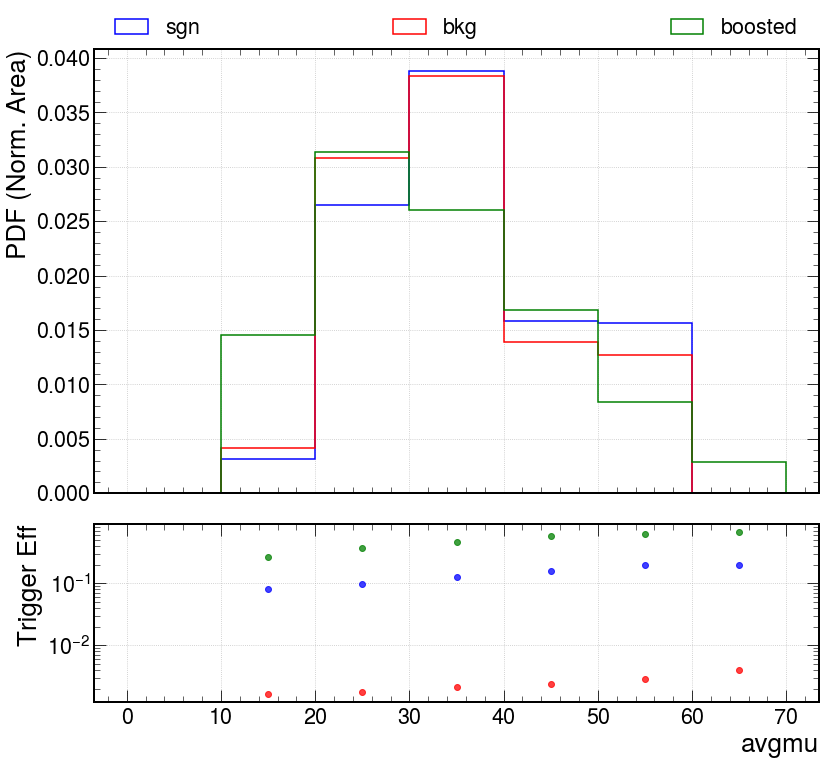

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Medium - et


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


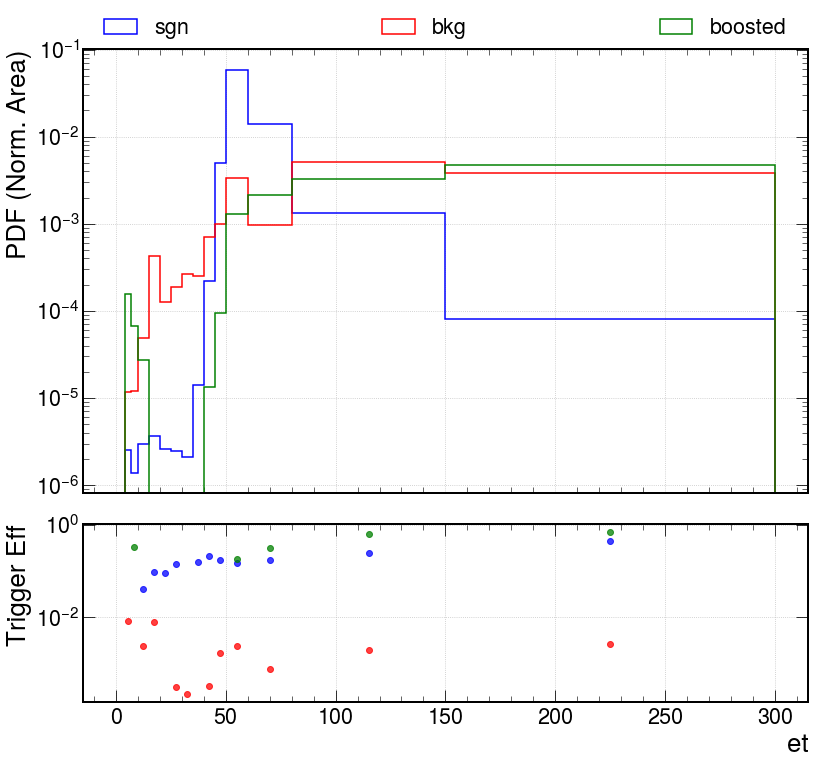

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Medium - eta


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


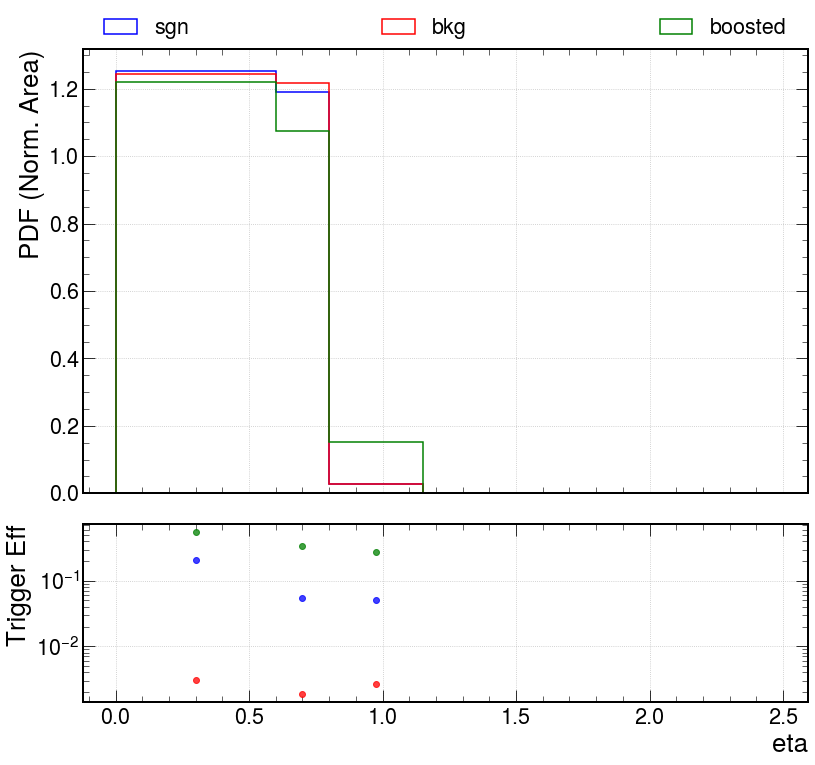

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Medium - phi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


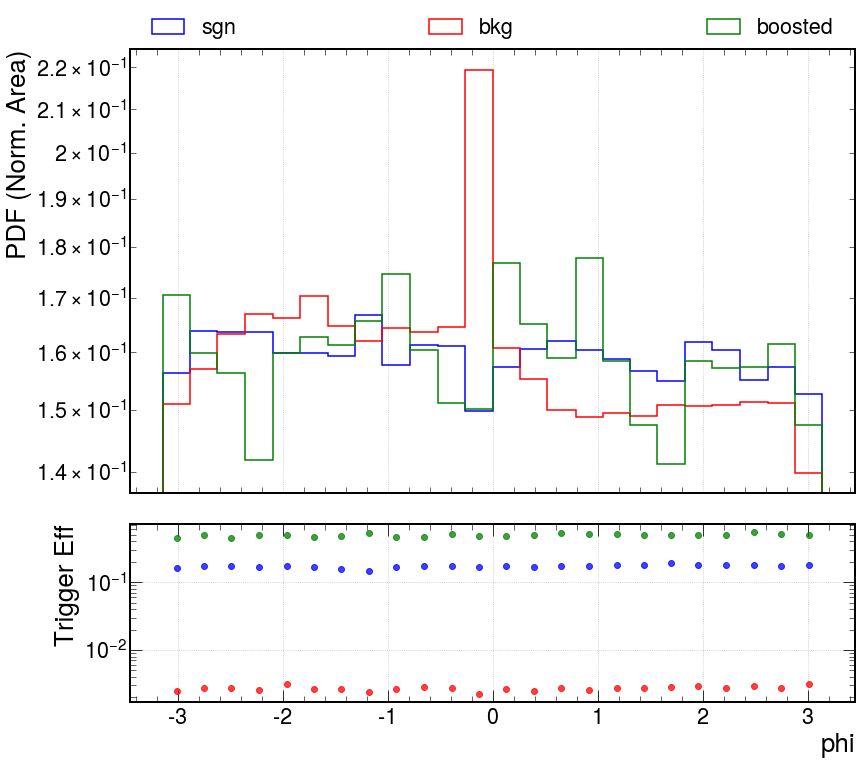

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Medium - avgmu


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


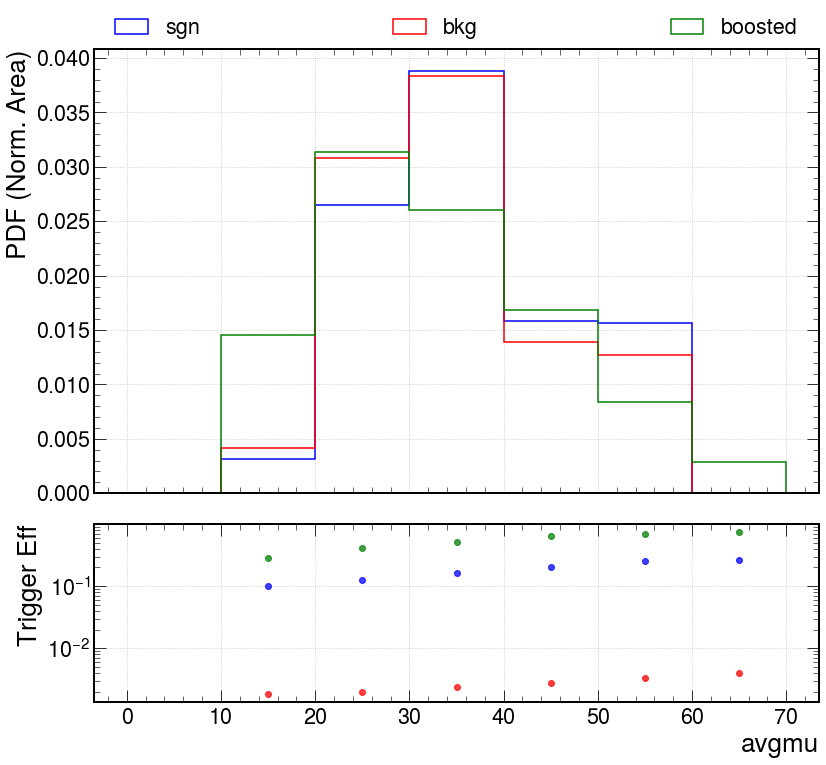

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Tight - et


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:285: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


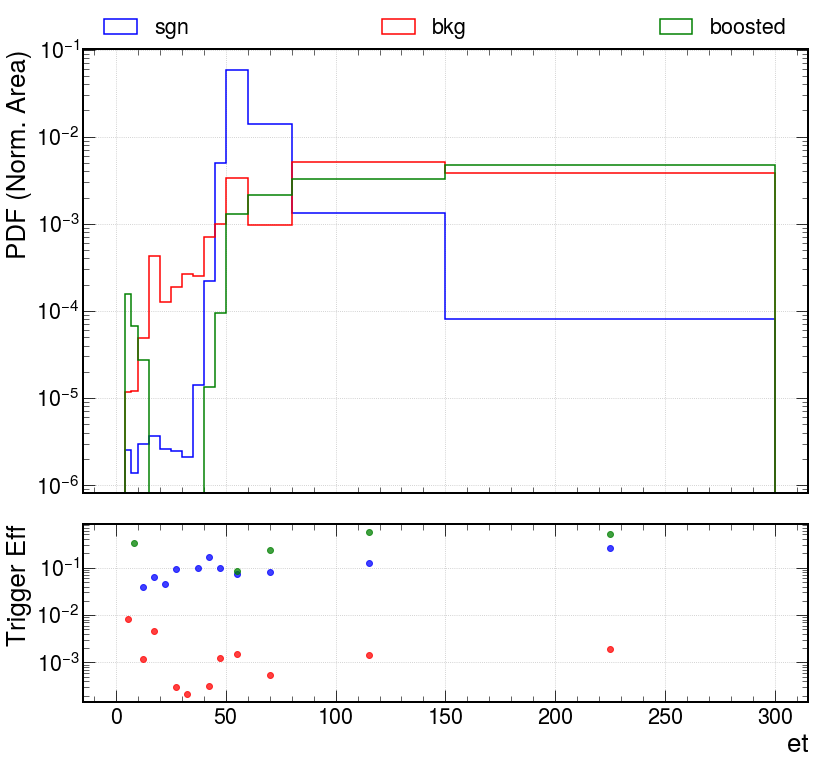

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Tight - eta


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


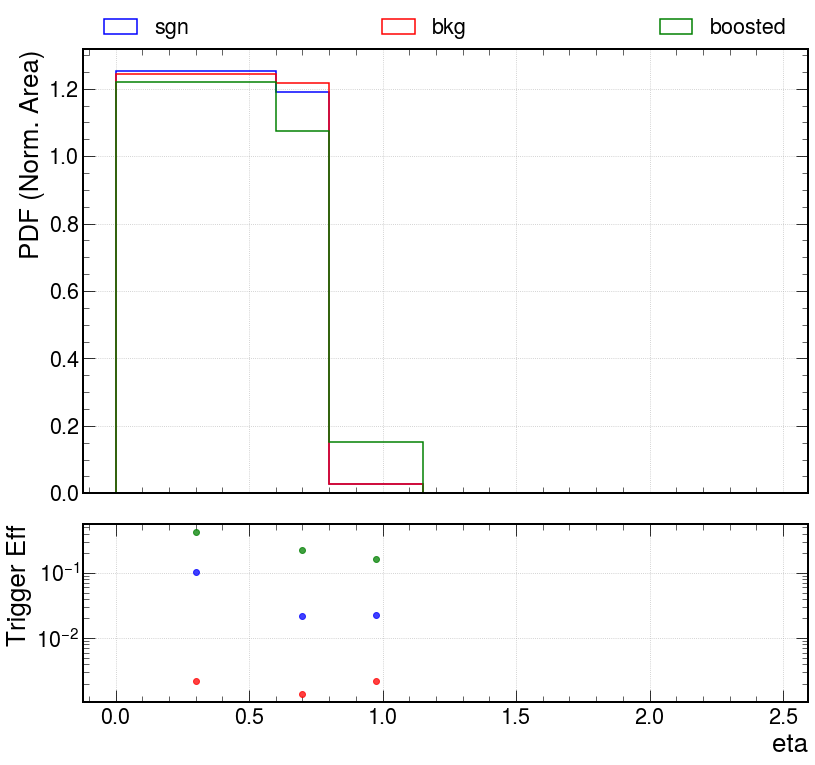

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Tight - phi


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


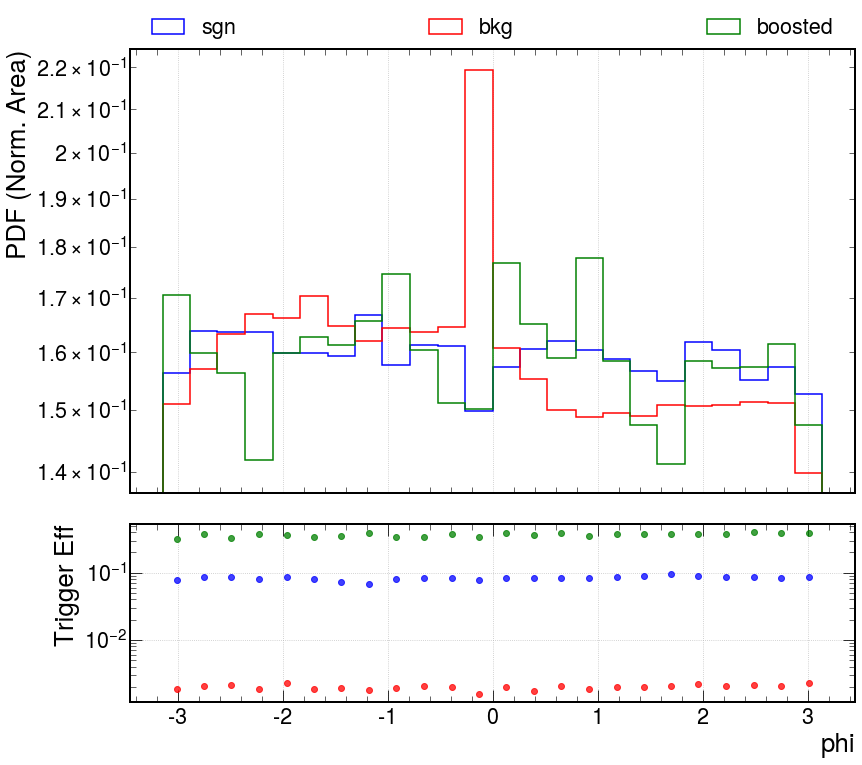

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


Processing Tight - avgmu


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


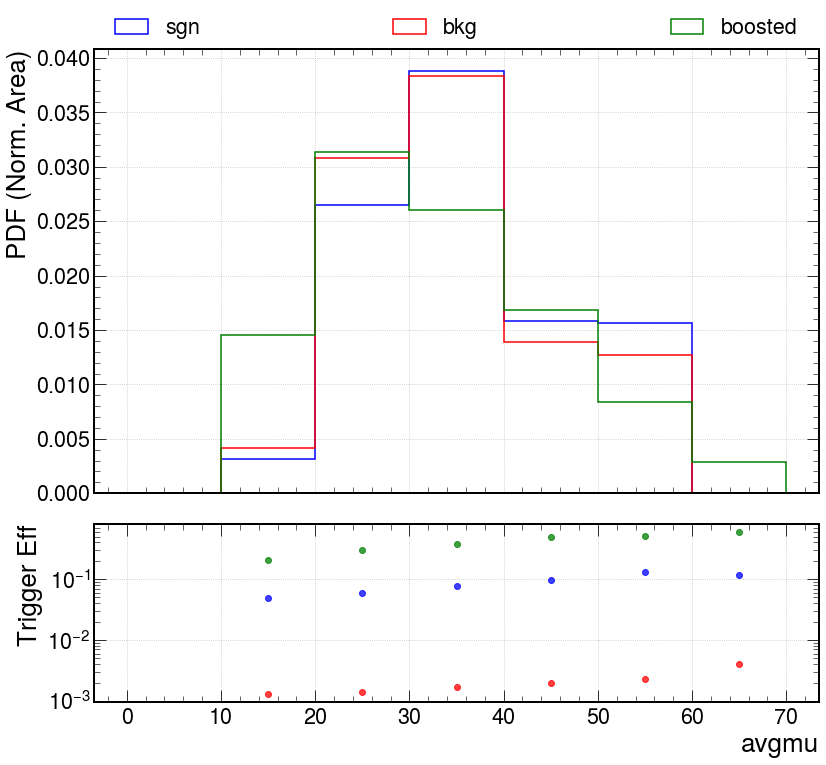

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [44]:
data = [df_zee, df_boosted]

variables = ['et', 'eta','phi', 'avgmu']
trigger_operation_points = ['VeryLoose','Loose', 'Medium', 'Tight']

for i_trigger_operation_point in trigger_operation_points:
    for variable in variables:
        print('Processing %s - %s'%(i_trigger_operation_point,variable))
        #variable = 'avgmu'
        #variable = 'avgmu'
        n_bins = 25 # meu padrão
        # calculo do minino dos minimos e do maximo dos maximos
        m_min = +999999999999
        m_max = -999999999999
        for idb in data:
            if idb[variable].min() < m_min:
                m_min = idb[variable].min()
            if idb[variable].max() > m_max:
                m_max = idb[variable].max()
        bins = np.round(np.linspace(m_min, m_max, n_bins),2)
        avgmu_bins =  [10, 20, 30, 40, 50, 60, 70] #avgmu
        et_bins = [4.,7.,10.,15.,20.,25.,30.,35.,40.,45.,50.,60.,80.,150.,300.] # et_bins
        eta_bins = [0,0.6,0.8,1.15,1.37,1.52,1.81,2.01,2.37,2.47] # eta_bins

        offline_ref = 'tight'
        target_variable = 'el_lh%s'%(offline_ref)
        trg_op_point = i_trigger_operation_point.lower()
        ringer_version = 'v8'
        ringer_variable = "nn_decision_%s_%s"%(trg_op_point,ringer_version)

        if variable == 'et':
            [fig,ax,ax1]  = plot_et_turn_on(df_sgn=df_sgn, df_bkg=df_bkg,df_boosted=df_boosted, 
                                            variable=variable, target_variable=target_variable, 
                                            ringer_variable=ringer_variable,bins=et_bins,verbose=False)
        elif variable == 'eta':
            [fig,ax,ax1]  = plot_turn_on(df_sgn=df_sgn, df_bkg=df_bkg,df_boosted=df_boosted, 
                                         variable=variable, target_variable=target_variable, 
                                         ringer_variable=ringer_variable,bins=eta_bins,verbose=False)
        elif variable == 'avgmu':
            [fig,ax,ax1]  = plot_turn_on(df_sgn=df_sgn, df_bkg=df_bkg,df_boosted=df_boosted, 
                                         variable=variable, target_variable=target_variable, 
                                         ringer_variable=ringer_variable,bins=avgmu_bins,verbose=False)
        else:
            [fig,ax,ax1]  = plot_turn_on(df_sgn=df_sgn, df_bkg=df_bkg,df_boosted=df_boosted, 
                                         variable=variable, target_variable=target_variable, 
                                         ringer_variable=ringer_variable,bins=bins,verbose=False, set_ylog=True)
        plt.show(fig)
        fig.savefig('images/turnon_%s_offlineRef_%s_ringerOp_%s_ringerVersion_%s.pdf'%(variable,offline_ref,
                                                                                trg_op_point,ringer_version,),
                    bbox_inches='tight',facecolor='white')
        fig.savefig('images/turnon_%s_offlineRef_%s_ringerOp_%s_ringerVersion_%s.png'%(variable,offline_ref,
                                                                                           trg_op_point,ringer_version,),
                    bbox_inches='tight',facecolor='white', dpi=150)